# Devoir PHYS-F-302, année académique 2019-2020/ YAVAS ONUR-JEROME SOMERS

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from math import exp
%matplotlib inline

# Introduction

Pour ce travail, nous étudierons plusierus méthodes numériques nous permettant de calculer, c'est-à-dire approximer la solution d'une équation dfférentielle. Pour ce faire, nous nous fierons également aux méthodes vu au premier quadrimestre. 

## Question 1 :


On a une équation du 4eme ordre à résoudre. Pour obtenir la solution générale de cette équation, nous l'avons résolu en remplacant les $$df/dx$$ par une inconnue m dans le but de la ramener au seconde ordre. Pour cette question, il n'est pas précisé d'utiliser numpy, nous nous sommes permis d'utiliser sympy. Ainsi, nous trouvons une solution analyique comme suit.

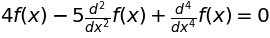

In [2]:
from sympy.interactive import printing
printing.init_printing(use_latex=True)
from sympy import *
import sympy as sp
x= sp.symbols('x')
f = sp.Function('f')(x)
diffeq = Eq(f.diff(x,x,x,x)-5*f.diff(x,x)+4*f, 0)
display(diffeq)
dsolve(diffeq,f)

## Question 2

Ecrire un code en python qui permet d'évaluer les constantes d'intégration de la solution générale en termes des conditions aux bords (2). Pour cette question vous pouvez vous servir de n'importe quelle routine fournie par numpy.

In [29]:

e=exp(1)
def p_exact(a,b,c,d):
        fo=[1,1,1,1]
        fprimo=[-2,-1,1,1]
        f1=[e**(-2),e**(-1),e,e**(2)]
        fprim1=[-2*e**(-2),-1*e**(-1),e,2*e**2]
        constantes = np.array([fo,fprimo,f1,fprim1])
        results = np.array([0,0,1,-1])
        find = np.linalg.solve(constantes,results)

## Question 3 :

[ 4.51341459 -6.77012189  2.95350869 -0.69680139]


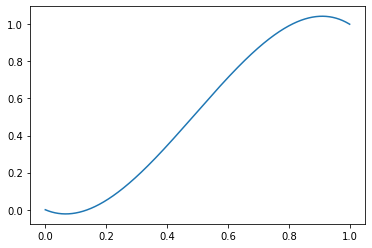

In [35]:
print(findconst(0,0,1,-1))

c1=findconst(0,0,1,-1)[0]
c2=findconst(0,0,1,-1)[1]
c3=findconst(0,0,1,-1)[2]
c4=findconst(0,0,1,-1)[3]

x= np.linspace(0,1,1000000)
f=lambda x: c1*e**(-2*x)+c2*e**(-1*x)+c3*e**(1*x)+c4*e**(2*x)


plt.plot(x,f(x))
plt.show()

## Question 4 

 A présent, nous allons utiliser la méthode de Gauss-Seidel qui nous permettre d'obtenir une solution approximer.
 
 La méthode de Gauss-Seidel est basé sur l'itération de d'un système linéaire ayant une forme  $Ax=b$. Plus précisément, c'est une suite qui convergera vers une solution de  l'équation étudiée. La méthode est valable si la solution existe et si les conditions de convergence sont satisfaites.
 
Nous allons reprendre l'algorithme, vu au MOOC-Relax, on va introduire nos conditions et demander à Jupyter de faire l'itération.

Pour obtenir, l'équation d'itération, il suffit d'utiliser la méthode de centrale finite, backward et forward. Comme nous avons l'application de ses méthodes en premier quadrimestre, ne ne trouvons pas utile de détaillé ces procédés ici. 

Remarque : sachant que le calcul prends énormément de temps, nous allons utiliser numba pour aller plus vite. 
 
 

In [36]:
import numba
from numba import jit

In [37]:
# Nos paramètres d'entrées sont :
nx = 101  # nnombre de points dans la grille selon la direction x
Lx = 1.0  # longueur du domaine selon x.
dx = Lx / (nx - 1)  # Espacement selon x.
x = np.linspace(0.0, Lx, num=nx) # localisation de nos points.

# Conditions initiales.
po = np.zeros(nx)
po[-1] = 1
po[0]=0


In [38]:
@jit(nopython=True)
def gauss_seidel(dx,po, maxiter, rtol):
    A = 6+10*dx**2+4*dx**4 #Coefficients 
    B = -4-5*dx**2 # Coefficients
    p = po.copy()
    conv = []  # convergence 
    diff = rtol + 1.0  # différence initiale
    ite = 0  # index d'itération
    
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        for i in range(2,nx-2):
            p[i] = (A**(-1))*(-p[i-2]-B*p[i-1]-B*p[i+1]-p[i+2])
        # Appliquons les conditions de VAN NEUMANN dans les bonnes conditions.
               
        p[-2]= p[-1]+dx
        p[1] = p[0]
        
        diff = np.sqrt(np.sum((p - pn)**2) / np.sum(pn**2)) #différence en norme L2 de deux itérations successives.
        conv.append(diff)
        ite += 1 
    return p, ite, conv

Gauss-Seidel relaxation: 2531638 iterations pour atteindre une différence relative de 9.99998581262672e-09


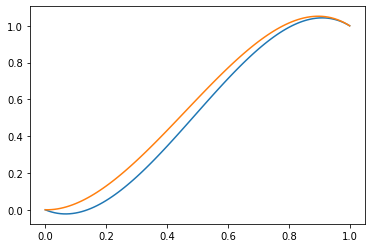

In [42]:
p_gauss, ites, conv_gs = gauss_seidel(dx,po,maxiter=20000000, rtol=1e-8)
print('Gauss-Seidel relaxation: {} iterations '.format(ites) +'pour atteindre une différence relative de {}'.format(conv_gs[-1]))
x = np.linspace(0.0, Lx, num=nx)
plt.plot(x,f(x))
plt.plot(x,p_gauss)
plt.show()

In [40]:
def L2_norm(p, pn):
    
    return np.sqrt(np.sum((p - pn)**2)/np.sum(pn**2))

In [41]:
erreur = L2_norm(p_gauss, f(x))
print("L2_norm entre solution exacte et Gauss Seidel",erreur)

L2_norm entre solution exacte et Gauss Seidel 0.09019533427892859


## Question 5 : 

En appliquant l'équation d'itération de manièere un peu plus différente, on peut utiliser la méthode Conjugate Gradiant.

 la méthode du gradient conjugué est un algorithme permettant de  résoudre des systèmes d'équations linéaires dont la matrice est symétrique définie positive, imaginée en 1950 par Cornelius Lanczos, Eduard Stiefel et Magnus Hestenes1, est une méthode itérative qui converge en un nombre fini d'itérations . Toutefois, son grand intérêt pratique du point de vue du temps de calcul vient de ce qu’une initialisation astucieuse (dite « préconditionnement ») permet d'aboutir en seulement quelques passages à une estimation très proche de la solution exacte.

In [43]:

def l2_norm(p, pk):
    
    return np.sqrt(np.sum((p - pk)**2)/np.sum(pk**2))

In [44]:
nx = 101
Lx = 1
dx = Lx/(nx-1)
b=0
maxiter = 20000000
rtol =1e-8
p0 = np.zeros(nx)

In [45]:

def conjugate_gradient(p0, b, dx, maxiter, rtol):
    
    a1= 6+10*dx**2+4*dx**4
    a2 = -4-5*dx**2                            
    def A(p):
        return a1*p[2:-2]+p[4:]+p[0:-4]+a2*p[3:-1]+a2*p[1:-3]
    # Conditions aux bords : 
    p = p0.copy() 
    p[0]=0     
    p[1]=0
    p[-1]=1
    p[-2]=p[-1]+dx 

    
    r = np.zeros_like(p)  # résidu initial
    Ad = np.zeros_like(p)  
   
    diff = rtol + 1  
    ite = 0  
    r[2:-2] = b - A(p) #formule
    d = r.copy() 
    
    while diff > rtol and ite < maxiter:
        
        
        pk = p.copy()
        rk = r.copy()
        Ad[2:-2] = A(d)
        alpha = np.sum(r * r) / np.sum(d * Ad)
        p = pk + alpha * d
        r = rk - alpha * Ad
        beta = np.sum(r * r) / np.sum(rk * rk)
        d = r + beta * d
        diff = l2_norm(p, pk)
        ite += 1
        
    return p, ite, diff

itérations 296
dernier l2_norm 3.2937347809513406e-09


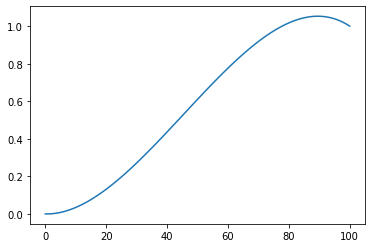

In [48]:
#on pose les variables et on lance l'algo :
nx = 101
Lx=1
dx = Lx/(nx-1)
b=0
maxiter = 20000000
rtol =1e-8
p0 = np.zeros(nx)


p_gradient, ites, last_difference = conjugate_gradient(p0, b, dx, maxiter, rtol)
print("itérations",ites)
print("dernier l2_norm",last_difference)
plt.plot(p_gradient)
plt.show()

In [50]:
erreur =  l2_norm(p_gradient, f(x))
print ("l2_norm entre solution exacte et p_gradient est de",erreur)

l2_norm entre solution exacte et p_gradient est de 0.09512726227463537


## Sources :
1.https://fr.wikipedia.org/wiki/M%C3%A9thode_du_gradient_conjugu%C3%A9

2.https://en.wikipedia.org/wiki/Finite_difference_coefficient

3.https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method

4.https://github.com/bknaepen/numerical-mooc/tree/MonteCarlo
    